# <font color='red'> <center> Probability and Statistics </font>
## <font color='red'> <center> Random Number Generation: Acceptance-Rejection Method</font>
## <font color='red'> <center> Benjamin Richards, June 2024</font>

The purpose of this report to explain the Acceptance-Rejection method for random number generation. It will begin by developing uniform random number generation, before moving on to non-uniform random number generation. The inverse CDF approach will developed briefly, and then the Acceptance-Rejection method will be explored in more detail. The final section will focus on certain applications of random number generation.

## <font color='red'> Overview </font> 
<font color='red' size=5>
<ul>
    <li>Section 1: Uniform Random Number Generation</li>
    <li>Section 2: Inverse CDF</li>
    <li>Section 3: Acceptance-Rejection</li>
    <li>Section 4: Further Applications</li>
</ul>
</font>

In [3]:
# All imports required for the notebook are done here
from functools import partial
import matplotlib.pyplot as plt
from numpy import array, append, sqrt, exp, pi, tan, linspace, log, where
from scipy.special import erf, erfc
from scipy.special import gamma as gamma_func
from scipy.optimize import fsolve
from scipy.integrate import quad
from time import  time
from typing import Callable
from warnings import filterwarnings


# Sometimes we get overflow warnings for
# random number generation
filterwarnings("ignore", category=RuntimeWarning)

## <font color='red'> Section 1 : Uniform Random Number Generation </font> 

The key to generating random numbers of any kind is to first generate uniform random numbers. Uniform random number generation is a whole research field in itself, and we will only touch on it very briefly here. 

The simplest method is called a congruential random generator, which, given some seed $x_0$, is of the form:

$$x_{i+1}=(ax_i+c)\text{mod}m$$

Where $a$, $c$, and $m$ are fixed. When $c$ is set to $0$, it is called a multiplicative congruential generator, otherwise its called mixed. Unfortunately, not all choices of $a$ and $m$ produce sufficiently random outputs, so they must be chosen carefully. 

All congruential generators will only produce a finite set of numbers before the set starts repeating itself. The length of this set is called the period. To ensure that the period is large enough for modern statistical applications, $m$ is typically quite large, for example, $m=2^{31}-1$, as $m$ represents the upper bound on the numbers generated. However, a large period does not guarantee high quality pseudo-randomness, as the underlying structure may still not be sufficiently dispersed.

To ensure the numbers produced are between 0 and 1, the $x_{i+1}$ are divided by $m$. 

For our purposes, we will require a slightly more complex generator, specifically, a linear combination of 3 multiplicative congruential generators, based on Wichmann and Hill (1983) [1]. Each of the 3 congruential generators have their own $a_g$ and $m_g$, and produce the $x_{ig}$ for $g\in\{1,2,3\}$. Then, the final number is calculated as
$$x_{i}=x_{i1}+x_{i2}+x_{i3}$$

In our case, we have
$$a1=171$$
$$m1=30269$$
$$a2=172$$
$$m2=30307$$
$$a3=170$$
$$m3=30323$$

The period of this generator is $2.78\times 10^{13}$

[1] B. A. Wichmann and I. D. Hill (1982). Algorithm AS 183: An Efficient and Portable Pseudo-Random Number Generator\
https://www.jstor.org/stable/2347988

In [4]:
class WH:
    # Constants for random number generation
    _a1 = 171   # Multiplier for seed1
    _m1 = 30269 # Modulus for seed1
    _a2 = 172   # Multiplier for seed2
    _m2 = 30307 # Modulus for seed2
    _a3 = 170   # Multiplier for seed3
    _m3 = 30323 # Modulus for seed3
    
    # Initial seeds for the random number generator
    seed1 = None
    seed2 = None
    seed3 = None

    def init_seeds(self, seed1: int, seed2: int, seed3: int) -> None:
        self.seed1 = seed1  # Set seed1 to the provided value
        self.seed2 = seed2  # Set seed2 to the provided value
        self.seed3 = seed3  # Set seed3 to the provided value

    def get_n_rand(self, n : int = 1) -> array:
        # Initialize seeds if not already initialized
        if self.seed1 is None:
            self.seed1 = int(time()) # Seed based on current time
        if self.seed2 is None:
            self.seed2 = int(time()) # Seed based on current time
        if self.seed3 is None:
            self.seed3 = int(time()) # Seed based on current time

        rands = array([]) # Initialize an empty numpy array for storing random numbers
        
        # Generate n random numbers
        for i in range(n):
            # Update seeds using linear congruential generator formula
            self.seed1 = (self._a1 * self.seed1) % self._m1
            self.seed2 = (self._a2 * self.seed2) % self._m2
            self.seed3 = (self._a3 * self.seed3) % self._m3
            
            # Combine the three seeds to generate a uniform random number
            temp = (
                self.seed1 / self._m1
                + self.seed2 / self._m2
                + self.seed3 / self._m3
            )
            
            # Ensure the generated number is in the range [0, 1)
            if temp > 2:
                temp -= 2
            if temp > 1:
                temp -= 1
            
            # Append the generated random number to the array
            rands = append(rands, temp)

        # If n was 1, return the single random number.
        # # Otherwise return the array of random numbers
        if n == 1:
            return rands[0]
        return rands

Sample mean:      0.5001765844843438
Sample variance:  0.08406223735955431


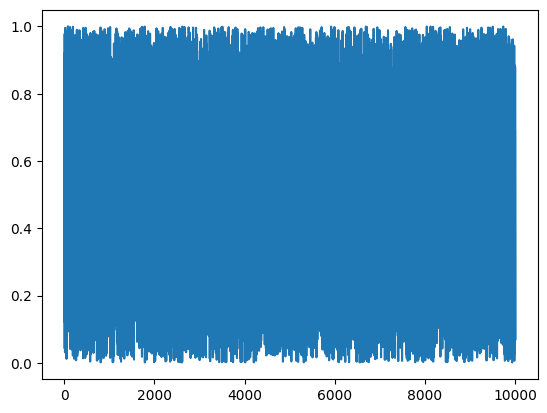

In [5]:
wh = WH()
n_rand = wh.get_n_rand(10000)

print('Sample mean:     ', n_rand.mean())       # Theoretical : 0.5
print('Sample variance: ', n_rand.var())        # Theoretical : 0.83333

plt.plot(n_rand)

Here we can see that the mean and variance are close the the theoretical values, and that the plot is approximately uniform.

## <font color='red'> Section 2 : Inverse CDF Approch </font> 

Now that we are able to generate uniform random numbers, the simplest approach for generating a non-uniform random number is to invert the CDF.

### <font color='red'> 2.1 The Algorithm </font> 
The algorithm for implementing the inverse CDF approach is straight forward. 

1. Generate $U$ from a uniform distribution over $[0,1]$. 
2. Return $X=F^{-1}(U)$.

### <font color='red'> 2.2 The Proof </font> 

The inverse CDF method is valid because of the following thoerem.

**Theorem 2.1**: <em>If U is a uniform random variable over $[0,1]$, then $F^{-1}(U)$ is a random variable with cdf $F$</em>. 

By definining, $F^{-1}(u)=\text{inf}\{x:F(x)\geq u\}$, the theorem follows by by first establishing:
$$F^{-1}(u)\leq x  \Leftrightarrow u\leq F(x)$$

Let $F^{-1}(u)$ then from the definition of $F^{-1}$, we have $u\leq F(F^{-1}(u))$ . Since $F$ is non-decreasing, we have $F(F^{-1}(u))\leq F(x)$ . Hence, $u\leq F(x)$. 

Let $u\leq F(x)$. Since $F$ is non-decreasing, and from the definition of infimums, we know that $F^{-1}(u)\leq F^{-1}(F(x))$. Since $F(x)\leq F(x)$, it follows that $F^{-1}(F(x))\leq F(x)$, and the result follows. 

Having established that, it is straight forward to prove the theorem. 

$$
\begin{align*}
P[F^{-1}(U)\leq x]&=P[U\leq F(x)]\\
&=F_U(F(x))\\
&=F(x)
\end{align*}
$$

Where we have used that fact that $F_U(x)=x$ for $x\in[0,1]$.

### <font color='red'> 2.3 Examples </font> 

#### <font color='red'> 2.3.1 Pareto </font> 

The Pareto distribution is described by a PDF of 
$$f(x)=\alpha\frac{\beta^\alpha}{x^{\alpha+1}}, \text{ where }x>\beta, \text{ and } \alpha,\beta >0$$

It is 0 otherwise. 

To calculate the CDF, we have
$$\begin{align*}
F(x) &= \int_{-\infty}^{x} \frac{\alpha \beta^\alpha}{t^{\alpha+1}} dt \\
     &= \int_{\beta}^{x} \frac{\alpha \beta^\alpha}{t^{\alpha+1}} dt \\
     &= \left[ -\frac{\beta^\alpha}{t^\alpha} \right]_{\beta}^{x} \\
     &= 1 - \left (\frac{\beta}{x} \right )^\alpha
\end{align*}$$

And so it easily follows that the inverse CDF is given by
$$F^{-1}(u)=\frac{\beta}{(1 - u)^{\frac{1}{\alpha}}}$$

#### <font color='red'> 2.3.2 Cauchy </font> 

The Cauchy distribution is described by a PDF and CDF of:
$$f_X(x)=\frac{1}{\pi}\frac{\gamma}{(x-x_0)^2+\gamma^2}$$
$$F_X(x)=\frac{1}{\pi}\text{tan}^{-1}(\frac{x-x_0}{\gamma})+\frac{1}{2}$$

We can easily invert $F_X$ to obtain
$$F^{-1}(u)=\gamma\text{tan}(\pi(u-\frac{1}{2}))+x_0$$

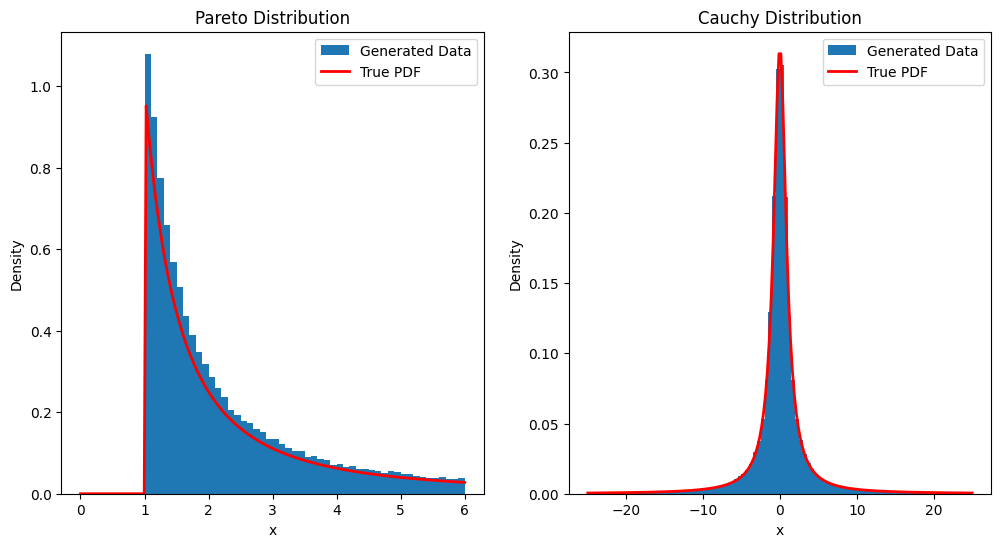

In [6]:
n = 100000

# Function to generate Pareto distributed random numbers
def gen_pareto(n: int, alpha: float, beta: float) -> array:
    # Generate n random numbers using WH class
    n_rand = wh.get_n_rand(n)  
    return beta / ((1 - n_rand) ** (1 / alpha))

# Probability Density Function (PDF) for Pareto distribution
def pareto_pdf(x: float, alpha: float, beta: float) -> array:
    if isinstance(x, float):
        if x <= beta:
            # PDF is 0 for x <= beta
            return 0  
        # Calculate PDF otherwise
        return alpha * (beta ** alpha) / (x ** (alpha + 1))  
    
    return where(
        x <= beta,
        0,
        alpha * (beta ** alpha) / (x ** (alpha + 1))
    )

alpha, beta = 1, 1
n_pareto = gen_pareto(n, alpha, beta)
# Filter output for values less than 6 for better plotting
n_pareto = n_pareto[n_pareto < 6]  

# Function to generate Cauchy distributed random numbers
def gen_cauchy(n: int, x0: float = 0, gamma: float = 1) -> array:
    # Generate n random numbers using WH class
    n_rand = wh.get_n_rand(n)  
    return gamma * tan(pi * (n_rand - 0.5)) + x0

# PDF for Cauchy distribution
def cauchy_pdf(array: array, x0: float = 0, gamma: float = 1) -> array:
    return (1 / pi) * (gamma / ((array - x0) ** 2 + gamma ** 2))

x0, gamma = 0, 1
n_cauchy = gen_cauchy(n, x0, gamma)
# Filter output for values within -25 to 25 for better plotting.
n_cauchy = n_cauchy[(n_cauchy > -25) & (n_cauchy < 25)]


# Plotting histograms and PDFs
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Pareto distribution
axes[0].hist(n_pareto, density=True, bins=50, label='Generated Data') 
x_pareto = linspace(0, 6, 200)
f_pareto = pareto_pdf(x_pareto, alpha, beta)
# Plot the PDF over the histogram
axes[0].plot(x_pareto, f_pareto, 'r-', linewidth=2, label='True PDF')  
axes[0].set_title('Pareto Distribution')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot for Cauchy distribution
axes[1].hist(n_cauchy, density=True, bins=100, label='Generated Data')  
x_cauchy = linspace(-25, 25, 200)
f_cauchy = cauchy_pdf(x_cauchy, x0, gamma)
# Plot the PDF over the histogram
axes[1].plot(x_cauchy, f_cauchy, 'r-', linewidth=2, label='True PDF')  
axes[1].set_title('Cauchy Distribution')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Density')
axes[1].legend()


## <font color='red'> Section 3 : Acceptance-Rejection </font> 

### <font color='red'> 3.1 The Algorithm </font> 

In some cases, it is not possible to use the inversion method of the CDF to generate a random variable, since the CDF is not guaranteed to be bijective, as is the case with discrete random variables. For continuous random variables, an analytical expression for the the inverse of the CDF is not always attainable either.

In this case, we can use the Acceptance-Rejection method. Given a density law $f$ for which that we would like to generate random variables, we require another density law $g$, called the generator. For the Acceptance-Rejection method to work, we need to find a constant $M$ such that $f(X)\leq Mg(X)$ for all $X$.

The method is the following:
1. Generate $X\sim g$ and $U\sim{\mathbf{U}}([0,1])$. 
2. If $U\leq f(X)/Mg(X)$ we accept $Y=X$ as a realisation of the density law $f$.
3. If $U>f(X)/Mg(X)$ we repeat 1. 

Since we have assumed $f(X)\leq Mg(X)$ we can write<br>
$$
\begin{align*}
\int_{-\infty}^\infty f(X)dx&\leq \int_{-\infty}^\infty Mg(X)dx\\
\int_{-\infty}^\infty f(X)dx&\leq M\int_{-\infty}^\infty g(X)dx\\
1&\leq M
\end{align*}
$$
Where we have applied the normalisation property to both $f$ and $g$. Hence, we have shown that $M$ cannot be less than 1. In fact, if $f(x)=g(x)$, then, necessarily, $M=1$.

### <font color='red'> 3.2 Proof </font> 

In order to prove that the Acceptance-Rejection method does indeed produce random deviates following the density law $f$, we must show that:
$$F_Y(y)=F_f(y)$$

In this section we will provide two approaches for showing this. 

#### <font color='red'> 3.2.1 Approach 1 </font> 

The approach taken here will depend on realising that the event $Y\leq y$ is the event $X\leq y$ conditional on the event $U\leq \frac{f(X)}{Mg(X)}$, and hence we can write

$$
\begin{align*}
F_Y(y)&=P[Y\leq y] \\ 
&=P[X\leq y | U\leq \frac{f(X)}{Mg(X)}] \\ 
&=\frac{P[X\leq y\cap U\leq \frac{f(X)}{Mg(X)}]}{P[U\leq \frac{f(X)}{Mg(X)}]}\\
\end{align*}
$$

We will treat the numerator and denominator separately. 

We can evaluate the probability $P[X\leq y\cap U\leq\frac{f(X)}{Mg(X)}]$ by using the joint PDF $f_{X,U}(x,u)$. $X$ and $U$ are also independent, so it follows that $f_{X,U}(x,u)=f_X(x)f_U(u)$.

Hence, we can write

$$
\begin{align*}
P[X\leq y\cap U\leq\frac{f(X)}{Mg(X)}]&=\int_{-\infty}^y\int_0^\frac{f(x)}{Mg(x)}f_{X,U}(x,u)dudx\\
&=\int_{-\infty}^y\int_0^\frac{f(x)}{Mg(x)}f_X(x)f_U(u)dudx\\
&=\int_{-\infty}^y f_X(x)\int_0^\frac{f(x)}{Mg(x)}dudx\\
&=\int_{-\infty}^y f_X(x)\frac{f(x)}{Mg(x)}dx\\
&=\frac{1}{M}\int_{-\infty}^y f(x)dx\\
&=\frac{1}{M}F_f(y)\\
\end{align*}
$$

Where we have used the fact that $f_X(x)=g(x)$, as defined by the problem, and $f_U(u)=1$, since $U$ is uniform over $[0,1]$.

It is straight forward to evaluate the expression for the denominator:
$$
\begin{align*}
P[U\leq\frac{f(X)}{Mg(X)}]&=\int_{-\infty}^\infty\int_0^\frac{f(x)}{Mg(X)}f_X(x)f_U(u)dudx\\
&=\frac{1}{M}
\end{align*}
$$

Where we have used a similar working to the above and also have applied the normalisation property to $f_X(x)$.

Combing these two we have:

$$
\begin{align*}
F_Y(y)&=P[Y\leq y] \\ 
&=P[Y\leq y | U\leq \frac{f(X)}{Mg(X)}] \\ 
&=\frac{P[X\leq y\cap U\leq \frac{f(X)}{Mg(X)}]}{P[U\leq \frac{f(X)}{Mg(X)}]}\\
&=\frac{\frac{1}{M}F_f(y)}{\frac{1}{M}}\\
&=F_f(y)
\end{align*}
$$

Which shows the desired result. 

 #### <font color='red'> 3.2.2 Approach 2 </font> 
In this approach, instead of considering the conditional probability $P[X\leq y | U\leq \frac{f(X)}{Mg(X)}]$, we note that the number of iterations required to yield $Y=X$ partitions the sample space.

In particular, let $N$ be the number of iterations needed for an acceptance. Then $N$ is a geometric random variable and
$$
\begin{align*}
P[N=i]&=P[\text{Acceptance on i}\cap\text{Rejection i-1 times}]\\
&=P[\text{Acceptance}]P[\text{Rejection}]^{i-1}
\end{align*}
$$

Where the second inequality follows since acceptance on $i$ is independent from any previous rejections. 

Note that the probabilities of acceptance and rejection are given by 
$$P[\text{Acceptance}]=P[U\leq\frac{f(X)}{Mg(X)}]$$
$$P[\text{Rejection}]=P[U>\frac{f(X)}{Mg(X)}]$$

Since $N$ partitions the sample space, using the total probability theorem, we can write
$$
\begin{align*}
P[Y\leq y]&=\sum_{i=1}^\infty P[Y\leq y\cap N=1]\\
&=\sum_{i=1}^\infty P[Y\leq y\cap\text{Acceptance on i}\cap\text{Rejection i-1 times}]\\
&=\sum_{i=1}^\infty P[Y\leq y,U\leq\frac{f(X)}{Mg(X)}]P[U>\frac{f(X)}{Mg(X)}]^{i-1}\\
&=\sum_{i=0}^\infty P[Y\leq y,U\leq\frac{f(X)}{Mg(X)}]P[U>\frac{f(X)}{Mg(X)}]^{i}\\
&=P[Y\leq y,U\leq\frac{f(X)}{Mg(X)}]\sum_{i=0}^\infty P[U>\frac{f(X)}{Mg(X)}]^{i}\\
&=P[Y\leq y,U\leq\frac{f(X)}{Mg(X)}]\frac{1}{1-P[U> \frac{f(X)}{Mg(X)}]}
\end{align*}
$$

Where have noted that since $P[U>\frac{f(X)}{Mg(X)}]$ is a probability, it is always less than or equal to 1, and we recognise the convergence of a geometric series.

From here, it is straightforward to rearrange into 

$$P[Y\leq y\cap U\leq\frac{f(X)}{Mg(X)}]=P[U\leq\frac{f(X)}{Mg(X)}]P[Y\leq y]$$

where we have applied $P[U\leq\frac{f(X)}{Mg(X)}]=1-P[U> \frac{f(X)}{Mg(X)}]$.

And finally
$$
\begin{align*}
P[Y\leq y]&=\frac{P[Y\leq y\cap U\leq\frac{f(X)}{Mg(X)}]}{P[U\leq\frac{f(X)}{Mg(X)}]}\\
&=\frac{P[X\leq y\cap U\leq\frac{f(X)}{Mg(X)}]}{P[U\leq\frac{f(X)}{Mg(X)}]}\\
&=\frac{\frac{1}{M}F_f(y)}{\frac{1}{M}}\\
&=F_f(y)
\end{align*}
$$

Where we have used results from the previous approach.


 #### <font color='red'> 3.2.3 Corollaries</font> 

From the foregoing, it is easy to see that the acceptance probability is equal to $\frac{1}{M}$, since we have already shown that 
$$P[U\leq\frac{f(X)}{Mg(X)}]=\frac{1}{M}$$

And the LHS represents the acceptance probability.

Since the number of iterations required for a success, $N$, is a geometric random variable with acceptance probability $p=\frac{1}{M}$, we know that $E[N]=\frac{1}{p}=M$. We can see that $M$ represents the average number of iterations needed to accept $X$ as $Y$. 

This tells us that we should carefully select $g$ so that $M$ is small. The closer $f$ and $g$ are to each other, the fewer iterations we need to simulate $f$. As noted above, if $f=g$, then necessarily $M=1$. This makes sense because if the densities are equal, then no rejections will occur and only one iteration will be required to accept $X$ as $Y$. 

### <font color='red'> 3.3 Example </font> 

 #### <font color='red'> 3.3.1 Cauchy and Normal</font> 

As an example of how we may determine $M$, consider generating a Cauchy random variable using the normal law.

For the $f$ and $g$ in this problem
$$C(0,1), f(x)=\frac{1}{\pi(1+x^2)}$$
$$N(0,1), g(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$$

Hence, we need to find $M$ such that<br>
$$\frac{1}{\pi(1+x^2)}\leq \frac{M}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$$
Rearranging, this implies that we need an $M$ such that<br>
$$\frac{\sqrt{2\pi}e^{\frac{x^2}{2}}}{\pi(1+x^2)}\leq M$$

However, note that the left hand side is an unbounded function. As $x$ increases, the numerator tends to infinity much faster than the denominator tends to 0. Hence, no such $M$ exists and we cannot generate a Cauchy variable using a Gaussian law.

On the other hand, it is possible to generate a Gaussian variable using the Cauchy law. 

Instead of the above, we take
    $$\frac{\pi(1+x^2)}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}\leq M$$
Where the RHS is now bounded. 
To solve for $M$, simply take the derivative with respect to $x$. We will take the derivative of the logged expression for convenience. 

$$l(x)=\frac{1}{\text{ln}(1+x^2)}-\frac{x^2}{2}$$
$$l'(x)=\frac{2x}{(1+x^2)}-x$$

Next, we can see that $l'(x)=0$ when $x=0$ or $x=\pm 1$. By plugging these values into the above, 



 #### <font color='red'> 3.3.2 Gamma and Exponential</font> 
It is possible to generate Gamma random deviataes using the exponential distribution as the instrumental density.

The PDF of the Gamma distribution is given by
$$f(x)=\frac{x^{\alpha - 1}e^{-x}}{\Gamma(\alpha)}, \text{ for } \alpha>1, x>0$$

where $\Gamma(\alpha)$ is the Gamma function. 

The exponential PDF is given by 

$$g(x)=\lambda e^{-\lambda x} \text{ for } \lambda, x>0$$

So we need to find $M$ such that 
$$\frac{f(x)}{g(x)}=\frac{x^{\alpha-1}e^{x(\lambda-1)}}{\lambda\Gamma(\alpha)}\leq M$$

Note that the LHS is unbounded if $\lambda \geq 1$ so we assume that $\lambda<1$.
Let $L$ denote the logged version of the LHS. Then we take the derivative.
$$
L = \ln x^{\alpha - 1} + x(\lambda - 1) - \ln (\lambda \Gamma (\alpha))
$$

$$
L' = \frac{\alpha - 1}{x} + \lambda - 1 = 0
$$

From which it follows that the maximum is attained by
$$
x = \frac{\alpha - 1}{1 - \lambda}
$$
Since $x \geq 0$, and $\alpha > 1$, we necessarily have that $\lambda < 1$.
Hence, we choose
$$
\begin{align*}
M &= \frac{\frac{\alpha - 1}{1 - \lambda}^{\alpha - 1}}{\Gamma (\alpha)} e^{\frac{\alpha - 1}{1 - \lambda} (\lambda - 1)}\\
&= \frac{\frac{\alpha - 1}{1 - \lambda}^{\alpha - 1}}{\lambda\Gamma (\alpha)} e^{-(\alpha - 1)}\\
\end{align*}
$$

To get $M$ as small as possible, and consequently, to minimize the expected number of needed iterations, we consider $M$ as a function of $\lambda$.
By taking the derivative of the logged expression of $M$ we have
$$
\frac{1}{\lambda} = \alpha
$$
And so the mean of the exponential distribution is $\alpha$. This is consistent with our earlier statement that $\lambda < 1$ since we have assumed $\alpha > 1$.



In [7]:
def accept_reject(
    n: int,                        # Number of random variates to generate
    target_pdf: Callable,          # Probability density function of the target distribution
    instr_pdf: Callable,           # Probability density function of the instrumental distribution
    target_gen: Callable,          # Generator function for the target distribution
    M: float,                      # Scaling factor M for the instrumental distribution
    ret_attempts: bool = False     # Flag to return the number of attempts per generated variate
)  -> array:
    deviates = []                  # List to store generated random variates
    attempts = []                  # List to store the number of attempts per accepted variate
    i = 0                          # Counter for the number of generated variates
    curr_attempt = 0               # Counter for attempts made in the current iteration

    while i < n:
        x = target_gen(1)    
        u = wh.get_n_rand()  
        
        curr_attempt += 1 

        # Acceptance criterion using the Accept-Reject method
        if u <= target_pdf(x) / (M * instr_pdf(x)):
            deviates.append(x)             # Accept x as a valid random variate
            i += 1                         
            attempts.append(curr_attempt)  # Record the number of attempts for this variate
            curr_attempt = 0               # Reset the attempt counter for the next iteration

    # Return either the generated variates and attempts, 
    # or a single variate if n == 1
    if ret_attempts:
        return array(deviates), array(attempts)
    if n == 1:
        return deviates[0]
    return array(deviates)


In [8]:
n = 100000

# Constant for normal distribution in Accept-Reject method
M_norm = sqrt(2*pi) * exp(-0.5)

# PDF of normal distribution
def normal_pdf(array: array, mean: float = 0, var: float = 1) -> array:
    return (1 / sqrt(2*pi*var)) * exp(-(((array - mean) / var) ** 2) / 2)

# Function to generate normal distributed random numbers using Accept-Reject method
def gen_normal(n: int, ret_attempts: bool = True) -> array:
    return accept_reject(
        n,
        normal_pdf,      # PDF of the normal distribution
        cauchy_pdf,      # PDF of the instrumental Cauchy distribution
        gen_cauchy,      # Generator for the instrumental Cauchy distribution
        M_norm,          # Scaling factor for the instrumental distribution
        ret_attempts,
    )

# Parameters for the gamma distribution
alpha = 2
lambda_ = 1 / alpha

# Constant for gamma distribution in Accept-Reject method
M_gamma = (
    (((alpha - 1) / (1 - lambda_)) ** (alpha - 1))
    * exp(-(alpha - 1))
    / (lambda_ * gamma_func(alpha))
)

# PDF of exponential distribution
def expon_pdf(x, lambda_):
    return lambda_ * exp(-x * lambda_)

# Generator for exponential distributed random numbers
def gen_expon(n, lambda_):
    n_rand = wh.get_n_rand(n)
    return - (log(1 - n_rand)) / lambda_

# PDF of gamma distribution
def gamma_pdf(x, alpha):
    return ((x ** (alpha - 1)) * exp(-x)) / gamma_func(alpha)

# Function to generate gamma distributed random numbers using Accept-Reject method
# partial is used to pass the function with specified arguments
def gen_gamma(n, ret_attempts=False):
    return accept_reject(
        n,
        partial(gamma_pdf, alpha=alpha),      # Partial function with fixed alpha
        partial(expon_pdf, lambda_=lambda_),  # Partial function with fixed lambda_
        partial(gen_expon, lambda_=lambda_),  # Partial function with fixed lambda_
        M_gamma,                              
        ret_attempts,
    )

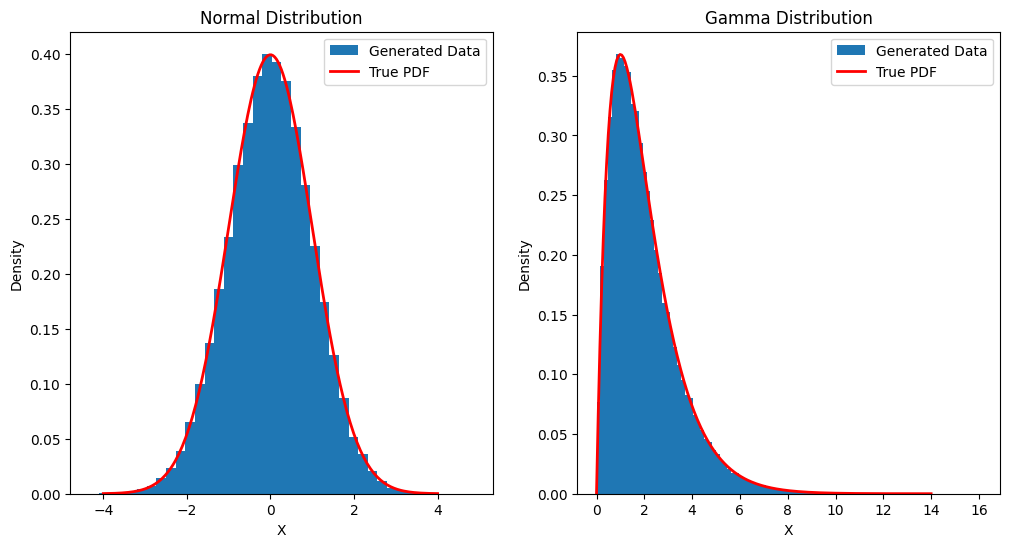

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Generate normal distributed random numbers and attempts made per variate
normals, attempts_norm  = gen_normal(n, ret_attempts=True)

# Plot histogram and overlay the actual PDF of normal distribution
axes[0].hist(normals, density=True, bins=40, label='Generated Data')
lin_in = linspace(-4, 4, 200)
axes[0].plot(lin_in, normal_pdf(lin_in), 'r-', linewidth=2, label='True PDF')
axes[0].set_title('Normal Distribution')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Density')
axes[0].legend()

# Generate gamma distributed random numbers and attempts made per variate
gammas, attempts_gamma = gen_gamma(n, ret_attempts=True)

axes[1].hist(gammas, density=True, bins=100, label='Generated Data')
lin_in = linspace(0, 14, 200)
axes[1].plot(lin_in, gamma_pdf(lin_in, alpha), 'r-', linewidth=2, label='True PDF')
axes[1].set_title('Gamma Distribution')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Density')
axes[1].legend()

In [10]:
print("Normal Distribution")
print('Average number of attempts:  ', array(attempts_norm).mean())
print('Expected number of attempts: ', M_norm)
print("\n")
print("Gamma Distribution")
print('Average number of attempts:  ', array(attempts_gamma).mean())
print('Expected number of attempts: ', M_gamma)

Normal Distribution
Average number of attempts:   1.515
Expected number of attempts:  1.5203469010662807


Gamma Distribution
Average number of attempts:   1.47059
Expected number of attempts:  1.4715177646857693


## <font color='red'> Section 4 : Further Applications </font> 

### <font color='red'> 4.1 Truncated Norm </font> 

In this section, we will explore generation of random variables from a truncated normal distribution. In particular, there are two methods: a simple approach, outlined below, and the Acceptance-Rejection method.

#### <font color='red'> 4.1.1 Simple approach </font> 

For the first method, consider the following algorithm:
1. Generate $X\sim N(0,1)$
2. If $X>s$ then we accept $Y=X$, otherwise repeat 1. 

This algorithms allows us to generate a random variable $Y$ having a density function
$$f(y)=\alpha I_{y>s}e^{-y^2/2}$$

To determine $\alpha$, first note that since $f(y)$ is a density function, we know that the normalisation property holds: 
$$\int_{s}^\infty \alpha e^{-y^2/2}dy=1$$

Where we have used the fact that $f(y)=0$ for $y\leq s$.

We can apply a change of variables in this case, with $u=y/\sqrt{2}$.
$$\int_{u>s/\sqrt{2}}^\infty\alpha\sqrt{2} e^{-u^2}du=1$$
$$\sqrt{\frac{\pi}{2}}\int_{u>s/\sqrt{2}}^\infty\frac{2}{\sqrt{\pi}}\alpha e^{-u^2}du=1$$

From here we recognise the complementary error function
$$\text{erfc}(x)=\frac{2}{\sqrt{\pi}}\int_x^\infty e^{-u^2}du$$

And conclude that
$$\alpha=\sqrt{\frac{2}{\pi}}\frac{1}{\text{erfc}(s/\sqrt{2})}$$



To calculate the acceptance probability, note that $Y=X$ if $X>S$. So we can consider
$$
\begin{align*}
P[X>s]&=\int_s^\infty\frac{1}{\sqrt{2\pi}}e^{-x^2/2}dx\\
&=\int_{s/\sqrt{2}}^\infty\frac{\sqrt{2}}{\sqrt{2\pi}}e^{-u^2}du\\
&=\int_{s/\sqrt{2}}^\infty\frac{1}{\sqrt{\pi}}e^{-u^2}du\\
&=\frac{1}{2}\int_{s/\sqrt{2}}^\infty\frac{2}{\sqrt{\pi}}e^{-u^2}du\\
&=\frac{1}{2}\text{erfc}(s/\sqrt{2})
\end{align*}
$$
where we have applied the same change in variable.

Let $P[X>s]=M_1^{-1}$. Since the number of iterations for acceptance is a geometric random variable, we immediately have that the mean is equal to $M_1$. 

#### <font color='red'> 4.1.2 Acceptance-Rejection </font> 

The second method for generating a truncated Gaussian random variable is acceptance-rejection approach using the generating density:
$$g(x)=I_{x\geq s}\lambda e^{-\lambda(x-s)}$$


Let $U\sim U([0,1])$ and $X=s-\frac{1}{\lambda}lnU$.\
We will show that $X$ has $g(x)$ as a density function.


$$
\begin{align*}
F_X(x)&=P[X\leq x]\\
&=P[s-\frac{1}{\lambda}lnU\leq x]\\
&=P[-\frac{1}{\lambda}lnU\leq x-s]\\
&=1-P[U\leq e^{-\lambda(x-s)}]\\
&=1-F_U(e^{-\lambda(x-s)})\\
&=1-e^{-\lambda(x-s)}\\
\end{align*}
$$

where we have used the fact that $F_U(u)=u$, since $U$ is uniform over $[0,1]$.

It follows easily by taking the derivative that 
$$f_X(x)=\lambda e^{-\lambda(x-s)}$$


In order for the acceptance-rejection method to work, we need to find an $M_2$ such that 
$$\frac{f(x)}{g(x)}\leq M_2$$
Hence, take
$$
\frac{f(x)}{g(x)}\leq\frac{\alpha e^{-x^2/2}}{\lambda e^{-\lambda(x-s)}}=\frac{\alpha}{\lambda}e^{-x^2/2+\lambda x-s\lambda} \\
$$

Note that the expression on RHS is bounded since functions of the form $e^{-x^2}$ are bounded.

To find the maximum, let $y$ be the logged expression
$$y=ln(\frac{\alpha}{\lambda})-\frac{x^2}{2}+\lambda x-s\lambda$$
Then
$$y'=-x+\lambda$$
And the maximum is $x=\lambda$, where we have set $y'=0$ to calculate.
<br>
Hence, we can set
$$M_2=\frac{\alpha}{\lambda}e^{\frac{\lambda^2}{2}-\lambda s}$$
And the below statement holds for all $x$
$$\frac{f(x)}{g(x)}\leq M_2$$

If we want to minimise the number of iterations required for an acceptance, note that $M_2$ is a function of $\lambda$. Hence, we can minimise $M_2$ by choosing an appropriate $\lambda$.
<br>
First take the log of $M_2$.
$$L_{M_2}=ln(\alpha)+ln(\frac{1}{\lambda})+\frac{\lambda^2}{2}-\lambda s$$
Then take the derivative and set it to 0.
$$L_{M_2}'=-\frac{1}{\lambda}+\lambda-s=0$$
This can be solved using the quadratic formula, and so we have
$$\lambda=\frac{s\pm \sqrt{s^2+4}}{2}$$
Since $\sqrt{s^2+4}>s$ and $\lambda$ must be positive, it follows that
$$\lambda=\frac{s+ \sqrt{s^2+4}}{2}$$

#### <font color='red'> 4.1.3 Comparison and Examples </font>

Given that
$$
\begin{align*}
M_1&=\frac{1}{\text{erfc}(\frac{s}{\sqrt{2}})}\\
M_2&=\sqrt{\frac{2}{\pi}}\frac{1}{\lambda\text{erfc}(\frac{s}{\sqrt{2}})}e^{\frac{\lambda^2}{2}-\lambda s}
\end{align*}
$$
We can find $s$ such that the expected number of attempts is equal for both methods by setting $M_1=M_2$ and solving for $s$.
Since both contain $\text{erfc}(\frac{s}{\sqrt{2}})$ in the denominator, this can be removed. 
And we have,
$$2=\sqrt{\frac{2}{\pi}}\frac{1}{\lambda}e^{\frac{\lambda^2}{2}-\lambda s}$$
Which gives
$$\text{ln}2\lambda\sqrt{\frac{\pi}{2}}=\frac{\lambda^2}{2}-\lambda s$$

Note however that $\lambda$ is a function of $s$, so we need to substitute $\lambda$ with $\frac{s+\sqrt{s^2+4}}{2}$

$$\text{ln}(2\cdot\frac{s+\sqrt{s^2+4}}{2}\cdot \sqrt{\frac{\pi}{2}})=\frac{\left ( \frac{s+\sqrt{s^2+4}}{2} \right )^2}{2} - \left ( \frac{s+\sqrt{s^2+4}}{2} \right )s$$

Which simplifies to
$$\text{ln}(s+\sqrt{s^2 + 4})+\text{ln}\sqrt{\frac{\pi}{2}}=\frac{(s+\sqrt{s^2 + 4})^2}{8}-\frac{(s+\sqrt{s^2 + 4})s}{2}$$

Obviously, this is very difficult, if not impossible, to solve analytically. A numerical solution is provided in the code for this section.

In [11]:
# Putting the code into classes will be particularly fruitful for this section.

# Define a base class for truncated normal distribution
class TruncNorm:

    def __init__(self, s):
        self.s = s          # Truncation threshold
        self._set_alpha()   # Compute alpha parameter

    def _set_alpha(self):
        # Compute alpha using the formula for truncated normal distribution
        self.alpha = sqrt(2 / pi) / erfc(self.s / sqrt(2))

    def trunc_norm_pdf(self, y):
        # PDF for truncated normal distribution
        if isinstance(y, float):
            if y <= self.s:
                return 0
            return self.alpha * exp(-(y**2) / 2)

        # Vectorized version for array input
        return where(
            y <= self.s,
            0,
            self.alpha * exp(-(y**2) / 2)
        )


# Subclass for Simple Approach truncated normal generation
class TruncNorm1(TruncNorm):

    def __init__(self, s):
        super().__init__(s)  # Initialise base class
        self._set_M()        # Compute M parameter

    def _set_M(self):
        # Compute M for the simple approach
        self.M = 1 / (0.5 * erfc(self.s / sqrt(2)))

    def gen_trunc_norm(self, n):
        deviates = []  # List to store generated variates
        attempts = []  # List to store number of attempts for each variate
        for _ in range(n):
            i = 0  # Counter for attempts
            trying = True
            while trying:
                i += 1
                # Generate a normal distributed random number
                x = gen_normal(1, ret_attempts=False)  
                if x > self.s:
                    deviates.append(x)
                    attempts.append(i)
                    trying = False
        return array(deviates), array(attempts)


# Subclass for Acceptance-Rejection truncated normal distribution
class TruncNorm2(TruncNorm):

    def __init__(self, s: float) -> None:
        super().__init__(s)  # Initialise base class
        self._set_lambda()   # Compute lambda parameter
        self._set_M()        # Compute M parameter

    def _set_lambda(self) -> None:
        # Compute lambda for the Acceptance-Rejection truncated normal distribution
        self.lambda_ = self.s + sqrt(self.s**2 + 4) / 2

    def _set_M(self) -> None:
        # Compute M for the Acceptance-Rejection truncated normal distribution
        self.M = (self.alpha / self.lambda_) * exp((self.lambda_**2 / 2) - self.lambda_ * self.s)

    def trunc_expon_pdf(self, x: array) -> array:
        # PDF for truncated exponential distribution used in the Acceptance-Rejection generation
        if x < self.s:
            return 0
        return self.lambda_ * exp(-self.lambda_ * (x - self.s))

    def trunc_expon_gen(self, n: int) -> array:
        # Generate random variates from truncated exponential distribution for the Acceptance-Rejection
        n_rand = wh.get_n_rand(n)
        return self.s - (1 / self.lambda_) * log(n_rand)

    def gen_trunc_norm(self, n: int, ret_attempts: bool = True) -> array:
        # Generate truncated normal variates using Accept-Reject method
        return accept_reject(
            n,
            self.trunc_norm_pdf,
            self.trunc_expon_pdf,
            self.trunc_expon_gen,
            self.M,
            ret_attempts
        )

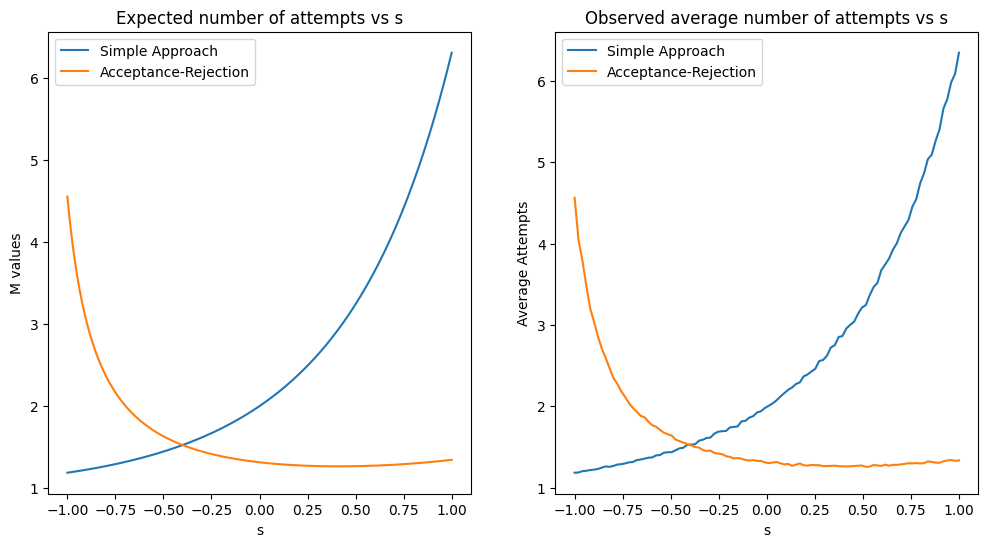

In [12]:

# Function to calculate M1 based on given s
def M1(s):
    return 2 / erfc(s / sqrt(2))

# Function to calculate M2 based on given s
def M2(s):
    alpha = sqrt(2 / pi) / erfc(s / sqrt(2))
    lambda_ = s + sqrt(s**2 + 4) / 2
    return (alpha / lambda_) * exp((lambda_ ** 2 / 2) - (lambda_ * s))

# Define range for s and calculate M1 and M2 for this range
# Bounds of -1 and 1 are chosen here because larger (smaller)
# values of s require significantly more attempts for acceptance. 
# In particular, the expected value of needed iterations for the
# Simple Approach is unbounded and reaches into the 30000s by s = 4.
s_ = linspace(-1, 1, 200)
M1_ = M1(s_)
M2_ = M2(s_)


S = linspace(-1, 1, 100)

# Lists to store average attempts for each s value
attempts1 = []
attempts2 = []

# A smaller n will go a long way here
n = 10000   

# Loop through each s value in S
for s in S:
    # Create instances of TruncNorm1 and TruncNorm2
    tn1 = TruncNorm1(s)
    tn2 = TruncNorm2(s)
    
    # Generate truncated normal samples and attempts for TruncNorm1
    y, a1 = tn1.gen_trunc_norm(n)
    
    # Generate truncated normal samples and attempts for TruncNorm2
    y2, a2 = tn2.gen_trunc_norm(n, True)
    
    # Calculate and store the mean number of attempts
    attempts1.append(a1.mean())
    attempts2.append(a2.mean())

# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot M1 and M2 values
axs[0].plot(s_, M1_, label='Simple Approach')
axs[0].plot(s_, M2_, label='Acceptance-Rejection')
axs[0].set_title('Expected number of attempts vs s')
axs[0].set_xlabel('s')
axs[0].set_ylabel('M values')
axs[0].legend()

# Plot average attempts for TruncNorm1 and TruncNorm2
axs[1].plot(S, attempts1, label='Simple Approach')
axs[1].plot(S, attempts2, label='Acceptance-Rejection')
axs[1].set_title('Observed average number of attempts vs s')
axs[1].set_xlabel('s')
axs[1].set_ylabel('Average Attempts')
axs[1].legend()


We can see from the graphs that the Acceptance-Rejection method performs better for larger values of $s$. This is confirmed with the theoretical values for $M$ and based on the numerical estimates. 

We can also see that at around $s=-0.4$, the Acceptance-Rejection method starts to outperform the Simple Approach. 

In [13]:
# Numerical solution to find s such that both methods
# have the same expected number of attempts

def equation_of_Ms(s):
    lam = (s + sqrt(s**2 + 4)) / 2
    left_side = log(2 * lam * sqrt(pi / 2))
    right_side = (lam**2 / 2) - lam * s
    return left_side - right_side

initial_guess = -0.4  # An initial guess for the solution based on the plots
solution = fsolve(equation_of_Ms, initial_guess)

print('Solution:', solution)

Solution: [-0.46983935]


In [14]:
s = solution[0]

t1 = TruncNorm1(s)
t2 = TruncNorm2(s)

# We can confirm that our alpha is correct
# by checking the normalisation property
integral, error = quad(t1.trunc_norm_pdf, s, float('inf'))
integral

1.0000000000000002

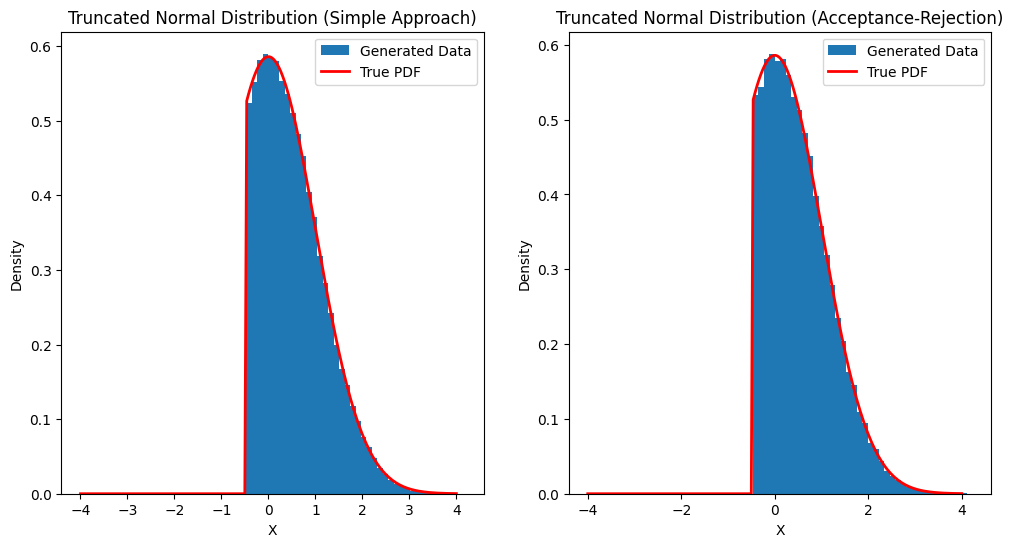

In [15]:
n = 100000

# Generate truncated normal samples and attempts for TruncNorm1 and TruncNorm2
y1, attempts1 = t1.gen_trunc_norm(n)
y2, attempts2 = t2.gen_trunc_norm(n)

# Create a subplot with 1 row and 2 columns for visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
lin_in = linspace(-4, 4, 200)  

# Plot histogram and PDF for TruncNorm1
axs[0].hist(y1, bins=40, density=True, label='Generated Data')  
axs[0].plot(lin_in, t1.trunc_norm_pdf(lin_in), 'r-', linewidth=2, label='True PDF')  
axs[0].set_title('Truncated Normal Distribution (Simple Approach)')  
axs[0].set_xlabel('X')  
axs[0].set_ylabel('Density')  
axs[0].legend()

# Plot histogram and PDF for TruncNorm2
axs[1].hist(y2, bins=40, density=True, label='Generated Data') 
axs[1].plot(lin_in, t2.trunc_norm_pdf(lin_in), 'r-', linewidth=2, label='True PDF')  
axs[1].set_title('Truncated Normal Distribution (Acceptance-Rejection)')  
axs[1].set_xlabel('X')  
axs[1].set_ylabel('Density')  
axs[1].legend()  



In [16]:
print("Truncated Norm Simple Approach")
print("Expected number of attempts:         ", t1.M)
print("Observed average number of attempts: ", attempts1.mean())
print("\n")
print("Truncated Norm Accept-Reject Approach")
print("Expected number of attempts:         ", t2.M)
print("Observed average number of attempts: ", attempts2.mean())

Truncated Norm Simple Approach
Expected number of attempts:          1.468935464943949
Observed average number of attempts:  1.46599


Truncated Norm Accept-Reject Approach
Expected number of attempts:          1.595711801205622
Observed average number of attempts:  1.59849


### <font color='red'> 4.2 Double Truncated Norm </font> 

#### <font color='red'> 4.2.1 Simple Approach </font>

The simple approach for generating one-sided truncated normal deviates can be easily extended to a double truncated norm.

For the algorithm, the acceptance condition is simply changed to $t>X>s$, and the density is given by
$$f(y)=\alpha I_{t>y>s}e^{-y^2/2}$$

Calculating $\alpha$ is done in a similar manner. 

We know that
$$\int_{s}^t \alpha e^{-y^2/2}dy=1$$

We can apply the same change of variables, namely, $u=y/\sqrt{2}$, and write
$$\sqrt{\frac{\pi}{2}}\int_{u>s/\sqrt{2}}^{t/\sqrt{2}>u}\frac{2}{\sqrt{\pi}}\alpha e^{-u^2}du=1$$

From here, we note that in general, $\int_a^{b}dt = \int_{-\infty}^b dt-\int_{-\infty}^a dt$, so it follows easily that
$$\alpha\sqrt{\frac{\pi}{2}}\left [\int_{-\infty}^{t/\sqrt{2}}\frac{2}{\sqrt{\pi}} e^{-u^2}du-\int_{-\infty}^{s/\sqrt{2}}\frac{2}{\sqrt{\pi}} e^{-u^2}du \right ]=1$$
$$\alpha\sqrt{\frac{\pi}{2}}\left [\text{erf}(\frac{t}{\sqrt{2}})-\text{erf}(\frac{s}{\sqrt{2}})\right ]=1$$
And so
$$\alpha=\sqrt{\frac{2}{\pi}}\frac{1}{\text{erf}(\frac{t}{\sqrt{2}})-\text{erf}(\frac{s}{\sqrt{2}})}$$

Note that in section 4.1.1 we used the complementary error function, $\text{erfc}$, while here we are using the error function itself.

In a similar manner to section 4.1.1, we can calculate the acceptance probability as
$$\begin{align*}
P[s<X<t]&=\int_s^t \frac{1}{\sqrt{2\pi}}e^{-x^2}dx\\
&=\frac{1}{2}\int_{s/\sqrt{2}}^{t/\sqrt{2}} \frac{2}{\sqrt{\pi}}e^{-u^2}dx\\
&=\frac{1}{2}\left [ \int_{-\infty}^{t/\sqrt{2}} \frac{2}{\sqrt{\pi}}e^{-u^2}dx - \int_{-\infty}^{s/\sqrt{2}} \frac{2}{\sqrt{\pi}}e^{-u^2}dx\right ]\\
&=\frac{1}{2}(\text{erf}(\frac{t}{\sqrt{2}})-\text{erf}(\frac{s}{\sqrt{2}}))\\
\end{align*}$$

Obviously, the expected number of iterations will be the inverse of this value, as the number of iterations remains a geometric variable.

#### <font color='red'> 4.2.2 Acceptance-Rejection </font>

Extending the Accept-Reject method as shown in section 4.1.2 to the case of double truncated norm is also fairly straight forward.

We take the instrumental density
$$g(x)=I_{t\geq x\geq s}\lambda e^{-\lambda(x+t-s)}$$

In a similar manner as before, its easy to show that $X=s-t-\frac{1}{\lambda}\text{ln}(U)$ has $g$ as its density function, as it only involves affine transformations. 

Determining $M$ such that $\frac{f(x)}{g(x)}\leq M$ also follows in a similar manner. 

$$\begin{align*}
\frac{f(x)}{g(x)}&=\frac{\alpha e^{-\frac{x^2}{2}}}{\lambda e^{-\lambda(x+t-s)}}\\
&=\frac{\alpha}{\lambda}e^{-\frac{x^2}{2}+\lambda x+\lambda(t-s)}\\
\end{align*}$$
By taking the log and derivative, it follows easily that $x=\lambda$ maximises $\frac{f(x)}{g(x)}$.
Hence, in this case
$$M=\frac{\alpha}{\lambda}e^{\frac{\lambda^2}{2}+\lambda(t-s)}$$

Then, similarly, we can take the derivative of $M$ with respect to $\lambda$ by first taking the log. 

$$L_M=\text{ln}\alpha - \text{ln}\lambda + \frac{\lambda^2}{2}+\lambda(t-s)$$
$$L_M'=-\frac{1}{\lambda}+\lambda+t-s$$

And so it follows that
$$\lambda=\frac{s-t\pm\sqrt{(t-s)^2+4}}{2}$$

Since $t>s$ by definition, $s-t<0$. To ensure that $\lambda$ is positive we need $s-t < \sqrt{(t-s)^2+4}$. \
If $s-t \geq \sqrt{(t-s)^2+4}$, then $(s-t)^2 \geq (t-s)^2+4$, and since $(s-t)^2=(t-s)^2$, it follows that $0\geq 4$. This is a contradiction, and hence $s-t < \sqrt{(t-s)^2+4}$.\
Hence,
$$\lambda=\frac{s-t+\sqrt{(t-s)^2+4}}{2}$$


In [17]:
class DoubleTruncNorm:
    # Base class

    def __init__(self, s: float, t: float) -> None:
        self.s = s          # Lower truncation bound
        self.t = t          # Upper truncation bound
        self._set_alpha()   # Calculate and set alpha value

    def _set_alpha(self) -> None:
        # Calculate the alpha constant for the truncated normal distribution
        self.alpha = sqrt(2 / pi) / (erf(self.t / sqrt(2)) -  erf(self.s / sqrt(2)))

    def double_trunc_norm_pdf(self, y: array) -> array:
        # Calculate the PDF of the double truncated normal distribution
        if isinstance(y, float):
            if y <= self.s or y >= self.t:
                return 0  # PDF is zero outside the truncation bounds
            return self.alpha * exp(-(y**2) / 2)

        # Vectorized calculation for arrays
        return where(
            (y <= self.s) | (y >= self.t),
            0,
            self.alpha * exp(-(y**2) / 2)
        )
    

class DoubleTruncNorm1(DoubleTruncNorm):
    # Simple Approach Generation

    def __init__(self, s: float, t: float):
        super().__init__(s, t)
        self._set_M()           # Calculate and set M value

    def _set_M(self) -> None:
        # Calculate the M constant for the acceptance-rejection method
        self.M = 1 / (0.5 * (erf(self.t / sqrt(2)) - erf(self.s / sqrt(2))))

    def gen_double_trunc_norm(self, n: float) -> array:
        # Generate n samples from the double truncated normal distribution
        deviates = []
        attempts = []
        for _ in range(n):
            i = 0
            trying = True
            while trying:
                i += 1
                x = gen_normal(1, ret_attempts=False)
                if self.s < x < self.t:
                    deviates.append(x)
                    attempts.append(i)
                    trying = False
        return array(deviates), array(attempts)
    

class DoubleTruncNorm2(DoubleTruncNorm):
    # Acceptance-Rejection Generation

    def __init__(self, s: float, t: float) -> None:
        super().__init__(s, t)
        self._set_lambda()  # Calculate and set lambda value
        self._set_M()       # Calculate and set M value

    def _set_lambda(self) -> None:
        # Calculate the lambda constant for the acceptance-rejection method
        self.lambda_ = ((self.s - self.t) + sqrt((self.t - self.s)**2 + 4))

    def _set_M(self) -> None:
        # Calculate the M constant for the acceptance-rejection method
        self.M = (self.alpha / self.lambda_) * exp(-(self.lambda_**2) * 0.5 + self.lambda_**2 + self.lambda_*(self.t - self.s))

    def double_trun_expon_pdf(self, x: array) -> None:
        # Calculate the PDF of the truncated exponential distribution
        if isinstance(x, float):
            if (x < self.s) or (x > self.t):
                return 0  # PDF is zero outside the truncation bounds
            return self.lambda_ * exp(-self.lambda_ * (x + self.t - self.s))
        
        # Vectorized calculation for arrays
        return where(
            (x < self.s) | (x > self.t),
            0,
            self.lambda_ * exp(-self.lambda_ * (x + self.t - self.s))
        )

    def double_trun_expon_gen(self, n: int) -> array:
        # Generate n samples from the truncated exponential distribution
        rand_n = wh.get_n_rand(n)
        return self.s - self.t - (1 / self.lambda_) * log(rand_n)

    def gen_double_trunc_norm(self, n: int, ret_attempts: bool = True) -> array:
        # Generate n samples from the double truncated normal distribution 
        # using acceptance-rejection method
        return accept_reject(
            n,
            self.double_trunc_norm_pdf,
            self.double_trun_expon_pdf,
            self.double_trun_expon_gen,
            self.M,
            ret_attempts
        )

In [18]:
s = -1
t = 1

dt1 = DoubleTruncNorm1(s, t)
dt2 = DoubleTruncNorm2(s, t)

# Check the normalisation property
integral, error = quad(dt1.double_trunc_norm_pdf, s, t)
integral

1.0

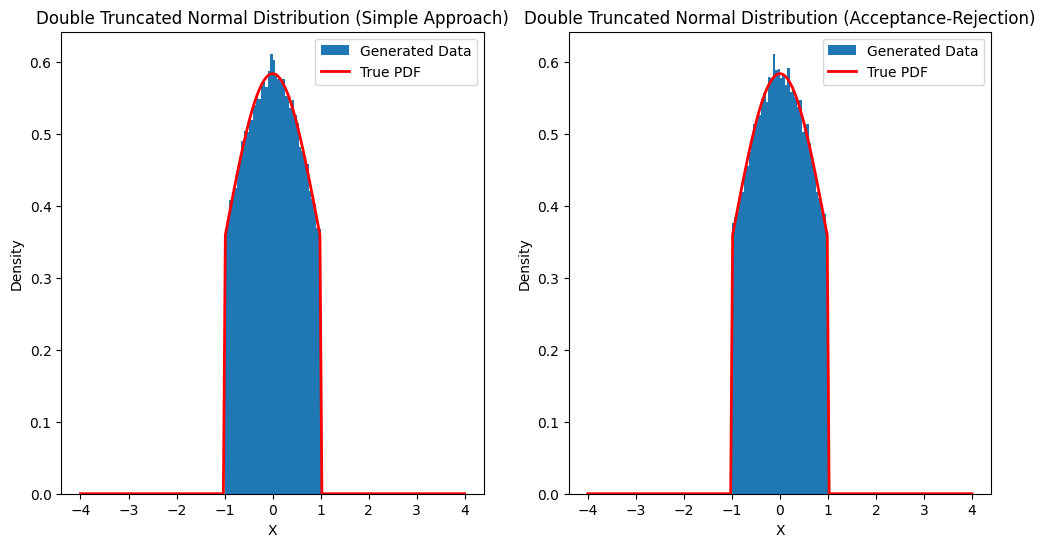

In [19]:
n = 100000

# Generate samples and attempts using DoubleTruncNorm1 and DoubleTruncNorm2
d_y1, d_attempts1 = dt1.gen_double_trunc_norm(n)
d_y2, d_attempts2 = dt2.gen_double_trunc_norm(n)

# Create a subplot with 1 row and 2 columns for visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
lin_in = linspace(-4, 4, 200) 

# Plot histogram and PDF for DoubleTruncNorm1
axs[0].hist(d_y1, bins=40, density=True, label='Generated Data') 
axs[0].plot(lin_in, dt1.double_trunc_norm_pdf(lin_in), 'r-', linewidth=2, label='True PDF')  
axs[0].set_title('Double Truncated Normal Distribution (Simple Approach)')  
axs[0].set_xlabel('X')  
axs[0].set_ylabel('Density')  
axs[0].legend()  

# Plot histogram and PDF for DoubleTruncNorm2
axs[1].hist(d_y2, bins=40, density=True, label='Generated Data')  
axs[1].plot(lin_in, dt2.double_trunc_norm_pdf(lin_in), 'r-', linewidth=2, label='True PDF')  
axs[1].set_title('Double Truncated Normal Distribution (Acceptance-Rejection)')  
axs[1].set_xlabel('X')  
axs[1].set_ylabel('Density') 
axs[1].legend()  


In [20]:
print("Double Truncated Norm Simple Approach")
print("Expected number of attempts:         ", dt1.M)
print("Observed average number of attempts: ", d_attempts1.mean())
print("\n")
print("Truncated Norm Accept-Reject Approach")
print("Expected number of attempts:         ", dt2.M)
print("Observed average number of attempts: ", d_attempts2.mean())

Double Truncated Norm Simple Approach
Expected number of attempts:          1.464794773491544
Observed average number of attempts:  1.46449


Truncated Norm Accept-Reject Approach
Expected number of attempts:          5.212205149892041
Observed average number of attempts:  5.21935
